# Birch clustering_unsupervised 

It is a memory-efficient, online-learning algorithm provided as an alternative to MiniBatchKMeans. It constructs a tree data structure with the cluster centroids being read off the leaf. These can be either the final cluster centroids or can be provided as input to another clustering algorithm such as AgglomerativeClustering.

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm, neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import metrics

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
train_split = 0.80
nrows = 250_000
path = 'c:/users/ugy1/abs/'
df=pd.read_csv(path+'datasets/processed_abs_loan_'+str(nrows)+'.csv', 
               #usecols=use_list, 
               #sep='\t',
               #compression=bz2,
               nrows=nrows,
               low_memory=False, 
              index_col=0, 
               parse_dates=True
              )
df.shape

(237024, 58)

In [3]:
column_list=df.columns.tolist()

In [4]:
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalanceeffectivedate_calc,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,label
0,66711.84,60,3.29,1,808.0,2.90,62677.27,0.0,3.3409,3.3409,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
1,16258.45,60,0.90,0,821.0,4.36,12793.38,0.0,0.9049,0.9049,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
2,31930.41,72,2.90,1,771.0,4.07,26981.85,0.0,2.9430,2.9430,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0
3,26065.02,65,0.90,0,890.0,5.00,4907.91,0.0,0.9037,0.9037,...,0.0,1,0,0.0093,0.99,3.86,0.68,0.59,0.92,0
4,42091.00,72,3.90,0,739.0,2.62,37060.44,0.0,3.9676,3.9676,...,0.0,1,0,0.0105,1.09,3.64,0.72,0.80,0.96,0


In [5]:
# prepare label for scikit-learn
Y=df.label.values
Y.shape

(237024,)

In [6]:
# prepare input data for scikit-learn
input=df.values
input.shape

(237024, 58)

In [7]:
# calculate train/test split

len_train = int(len(input)*train_split)
print(len_train)

189619


In [8]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]
x_train = input[0:len_train]
x_test = input[len_train:]
x_train.shape

(189619, 58)

In [9]:
export_x_test = pd.DataFrame(data=x_test)

In [10]:
export_x_test.columns=column_list
export_x_test.rename(columns={'label':'True Label'}, inplace=True)
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalanceeffectivedate_calc,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label
0,36863.24,72.0,1.00,1.0,871.0,2.59,20842.67,0.0,1.0042,1.0042,...,0.0,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0
1,23811.32,60.0,1.90,0.0,845.0,4.12,7241.37,0.0,1.9163,1.9163,...,0.0,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,0.0
2,30669.00,48.0,1.00,1.0,863.0,10.67,21859.06,0.0,1.0055,1.0055,...,0.0,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0
3,54083.21,72.0,1.00,0.0,682.0,4.42,50431.21,0.0,1.0045,1.0045,...,0.0,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0
4,31557.75,72.0,3.89,1.0,761.0,2.56,22262.79,0.0,3.9584,3.9584,...,0.0,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0


In [11]:
#from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

In [12]:
x_scaler=StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.fit_transform(x_test)

In [13]:
n_clusters=2
birch = cluster.Birch(n_clusters=n_clusters).fit(x_test)

In [14]:
#x_pred = x_test

In [15]:
prediction_birch = birch.labels_

In [16]:
np.unique(prediction_birch)

array([0, 1], dtype=int64)

In [17]:
np.bincount(np.array(prediction_birch).reshape(1,prediction_birch.size)[0])

array([46215,  1190], dtype=int64)

In [18]:
export_x_test['Predicted Label']=prediction_birch

In [19]:
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label,Predicted Label
0,36863.24,72.0,1.00,1.0,871.0,2.59,20842.67,0.0,1.0042,1.0042,...,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0,0
1,23811.32,60.0,1.90,0.0,845.0,4.12,7241.37,0.0,1.9163,1.9163,...,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,0.0,0
2,30669.00,48.0,1.00,1.0,863.0,10.67,21859.06,0.0,1.0055,1.0055,...,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0,0
3,54083.21,72.0,1.00,0.0,682.0,4.42,50431.21,0.0,1.0045,1.0045,...,1.0,0.0,0.0105,1.09,3.64,0.72,0.80,0.96,0.0,0
4,31557.75,72.0,3.89,1.0,761.0,2.56,22262.79,0.0,3.9584,3.9584,...,1.0,0.0,0.0110,1.11,3.28,0.66,1.08,0.89,0.0,0


In [20]:
export_x_test.shape

(47405, 59)

In [21]:
export_x_test.to_csv(path+"prediction/birch/predicated_birch_abs_loans_"+str(nrows)+".csv", chunksize=10000)

In [22]:
from sklearn import metrics
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, prediction_birch))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, prediction_birch))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, prediction_birch))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y_test, prediction_birch))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y_test, prediction_birch))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_test, prediction_birch))

Estimated number of clusters: 2
Homogeneity: 0.680
Completeness: 0.800
V-measure: 0.735
Adjusted Rand Index: 0.853
Adjusted Mutual Information: 0.680
Silhouette Coefficient: 0.518


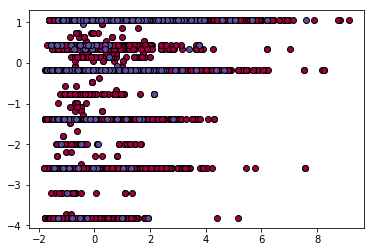

In [28]:
labels= birch.labels_
core_samples_mask = np.zeros_like(birch.labels_, dtype=bool)
#core_samples_mask[birch.core_sample_indices_] = False
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = x_test[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = x_test[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

#plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [30]:
def plot_confusion_matrix(cm, title, classes=['Current', 'Non_Current'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [31]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

             precision    recall  f1-score   support

    Current       0.99      1.00      1.00     45938
Non_Current       0.96      0.78      0.86      1467

avg / total       0.99      0.99      0.99     47405

AUC:  89.0%


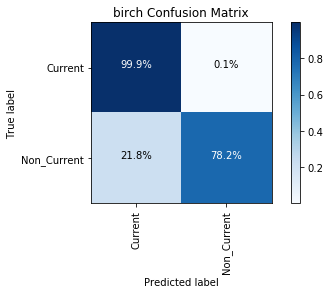

In [32]:
print(classification_report(y_test, prediction_birch, target_names=['Current', 'Non_Current']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, prediction_birch)))
cm = confusion_matrix(y_test, prediction_birch)
plot_confusion_matrix(cm, title="birch Confusion Matrix",save=True, 
                      saveas='prediction/birch/cm'+str(' birch Accuracy-')+str(nrows)+'.jpg')


ROC_AUC_SCORE ;  0.890465856547
Confusion matrix, without normalization
[[45895    43]
 [  320  1147]]


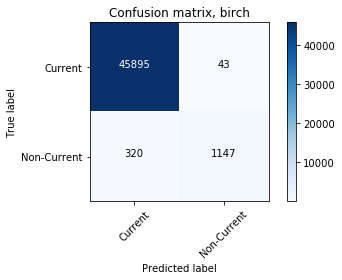

In [33]:
class_names = ['Current', 'Non-Current']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, prediction_birch))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_birch)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title= 'Confusion matrix, birch')
plt.savefig('prediction/birch/cm'+str(' birch Complete-')+str(nrows)+'.jpg')
plt.show()